[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# 에이전트 메모리

## 복습

이전 시간에 다음과 같은 기능을 가진 에이전트를 구축했습니다:

* `act(행동)` - 모델이 특정 도구를 호출할 수 있도록 합니다
* `observe(관찰)` - 도구 출력을 모델로 다시 전달합니다
* `reason(추론)` - 모델이 도구 출력에 대해 추론하여 다음 행동(예: 다른 도구 호출 또는 직접 응답)을 결정할 수 있도록 합니다

![](https://i.imgur.com/eEknwcr.png)

## 목표

이제 에이전트에 메모리 기능을 도입하여 확장해 보겠습니다.

In [13]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [14]:
import os, getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

[tracing](https://docs.smith.langchain.com/concepts/tracing)을 위해 [LangSmith](https://docs.smith.langchain.com/)를 사용할 것입니다.

In [15]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

다음은 이전 시간에 작성했던 코드와 동일합니다.

In [ ]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(
    content="당신은 일련의 입력값에 대해 산술 연산을 수행하는 임무를 맡은 유용한 보조자입니다."
)


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

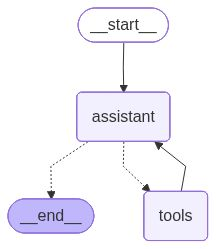

In [18]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory(메모리)

에이전트를 실행해 봅시다.

In [ ]:
messages = [HumanMessage(content="3과 4를 더하세요.")]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

3과 4를 더하세요.
================================== Ai Message ==================================
Tool Calls:
  add (call_fNWjnNW7D6BJMrzh5dkjlolX)
 Call ID: call_fNWjnNW7D6BJMrzh5dkjlolX
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

3과 4를 더하면 7입니다.


자, 이제 2를 곱해 보자!

In [ ]:
messages = [HumanMessage(content="그 값을 2를 곱하세요.")]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

그 값을 2를 곱하세요.
================================== Ai Message ==================================

곱하고자 하는 값을 제공해 주시면, 제가 그 값에 2를 곱할 수 있습니다.


대화에서 이전 계산 결과값 7에 대한 기억을 유지하지 않습니다!

이는 [상태가 일시적](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220)이기 때문입니다.

물론 이는 중단이 있는 다중 대화 진행 능력을 제한합니다.

이를 해결하기 위해 [지속성](https://langchain-ai.github.io/langgraph/how-tos/persistence/)을 활용할 수 있습니다!

LangGraph는 체크포인터(checkpointer)를 사용해 각 단계 후 그래프 상태를 자동 저장합니다.

이 내장 지속성 계층은 메모리를 제공하여 LangGraph가 마지막 상태 업데이트에서 작업을 재개할 수 있게 합니다.

사용하기 가장 쉬운 체크포인터 중 하나는 그래프 상태를 위한 인메모리 키-값 저장소인 `MemorySaver`입니다.

체크포인터와 함께 그래프를 컴파일하기만 하면, 그래프에 메모리가 부여됩니다!

In [21]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

메모리를 사용할 때는 `thread_id`를 지정해야 합니다.

이 `thread_id`는 그래프 상태 컬렉션을 저장합니다.

다음은 개념도입니다:

* 체크포인터는 그래프의 각 단계에서 상태를 기록합니다
* 이 체크포인트는 스레드에 저장됩니다
* 향후 `thread_id`를 사용하여 해당 스레드에 접근할 수 있습니다

![](https://i.imgur.com/komusXJ.png)

In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="3과 4를 더하세요.")]

# Run
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

3과 4를 더하세요.
================================== Ai Message ==================================
Tool Calls:
  add (call_AkLtVAqsdrMHh52JXor03fOc)
 Call ID: call_AkLtVAqsdrMHh52JXor03fOc
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

3과 4를 더하면 7입니다.


동일한 `thread_id`를 전달하면, 이전에 기록된 상태 체크포인트에서 진행할 수 있습니다!

이 경우, 위 대화 내용이 스레드에 캡처됩니다.

전달한 `HumanMessage`(`"그 값에 2로 곱하세요."`)는 위 대화 끝에 추가됩니다.

따라서 모델은 이제 `그 값`이 `3과 4의 합은 7입니다.`를 가리킨다는 것을 알게 됩니다.

In [ ]:
messages = [HumanMessage(content="그 값에 2로 곱하세요.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

3과 4를 더하세요.
================================== Ai Message ==================================
Tool Calls:
  add (call_AkLtVAqsdrMHh52JXor03fOc)
 Call ID: call_AkLtVAqsdrMHh52JXor03fOc
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

3과 4를 더하면 7입니다.
================================ Human Message =================================

그 값에 2로 곱하세요.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_x8bjDpwODA21X2ZlHDAEnCwi)
 Call ID: call_x8bjDpwODA21X2ZlHDAEnCwi
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

7에 2를 곱하면 14입니다.
